# Initializing

## Import

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models
from sklearn.model_selection import train_test_split
import os
from google.colab import drive
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv



drive.mount('/content/drive')
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Fourier_Test/Watermarking_Classes.ipynb'
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/MyWatermarkinClasses.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset Images

In [2]:
folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Training_128_400_Samples'

training_image_array = []
target_size = (128, 128)  # Resize to desired shape (width, height)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        im = my_image.astype(np.float32)
        im = np.expand_dims(im, axis=-1)
        im = im / 255.0
        im = im[:,:,0]
        training_image_array.append(im)

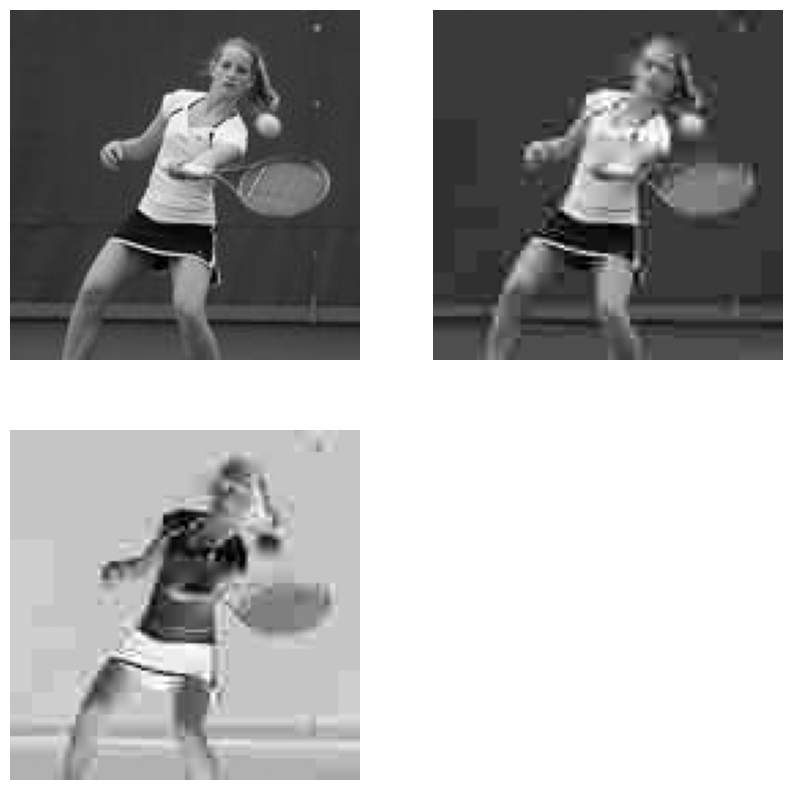

In [3]:
test_index = 11
temp_attacked_image = Channel(training_image_array[test_index]).jpeg_compress_grayscale_image(10)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(training_image_array[test_index], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(temp_attacked_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(training_image_array[test_index] - temp_attacked_image, cmap='gray')
plt.axis('off')

plt.show()


## ** Hyper Parameters

In [4]:
# Class Parameters
class1 = 5  # Frequency
class2 = 10 # Frequency
class3 = 15 # Frequency
class4 = 20 # Frequency


# Generate training, validation, and test data
# num_train_samples = 60_000
# num_val_samples = 16_000
# num_test_samples = 4_000

num_train_samples = 22_000
num_val_samples = 3_000
num_test_samples = 2_000


# Circle Mask Parameter
mask_ratio = 0.5 # Circle Mask



# Model Parameters
training_epochs = 10


# Channel Parameters



# min_attack_parameter = 1 # x_shift_attack
# max_attack_parameter = 40 # x_shift_attack

# min_attack_parameter = 1 # rotation_attack
# max_attack_parameter = 10 # rotation_attack

# min_attack_parameter = 0.05 # add_guassian_noise
# max_attack_parameter = 1 # add_guassian_noise

# min_attack_parameter = 0.05 # add_random_noise
# max_attack_parameter = 2 # add_random_noise

# min_attack_parameter = 0.01 # add_salt_and_pepper_noise
# max_attack_parameter = 0.02 # add_salt_and_pepper_noise

# min_attack_parameter = 2 # Blure
# max_attack_parameter = 5 # Blure


min_attack_parameter = 35 # jpeg_compress_grayscale_image
max_attack_parameter = 75 # jpeg_compress_grayscale_image

# min_attack_parameter = 0.4 # crop attack
# max_attack_parameter = 0.99 # crop attack

# min_attack_parameter = 0.01 # brightness attack
# max_attack_parameter = 0.6 # brightness attack

# min_attack_parameter = 0.01 # contrast attack
# max_attack_parameter = 1 # contrast attack

## Atacks

# attack_flag = 1 # x_shift_attack
# attack_flag = 2 # rotation_attack
# attack_flag = 3 # add_guassian_noise
# attack_flag = 4 # add_random_noise
# attack_flag = 5 # add_salt_and_pepper_noise
# attack_flag = 6 # blur_image
# attack_flag = 7 # crop_image
attack_flag = 8 # jpeg_compress_grayscale_image
# attack_flag = 9 # brightness
# attack_flag = 10 # contrast



# Created Data

In [5]:
# Function to generate WavePattern noise

def created_clean_data(num_samples, image_size, class_parameter, mask_ratio):
  data = Data(num_samples, image_size , mask_ratio)
  data_arr = data.Created_Masked_PN_Arr(class_parameter)

  return data_arr

def created_dirty_dataset(image_array,
                          num_samples,
                          class_parameter,
                          mask_ratio,
                          attack_flag,
                          min_attack_parameter,
                          max_attack_parameter):

    image_size = image_array[0].shape[0]

    clean_set = np.zeros((num_samples // 2, image_size, image_size))
    dirty_set1 = np.zeros_like(clean_set)

    for i in range(num_samples // 2):

      # Generate Dirty Set
      # attack_parameter = np.random.uniform(min_attack_parameter, max_attack_parameter + 1e-10)
      attack_parameter = np.random.randint(min_attack_parameter, max_attack_parameter + 1)

      dirty_set1[i, :, :] = created_dirty_data(image_array, mask_ratio, class_parameter, attack_flag, attack_parameter)

      # Generate Clean Set
      clean_set[i, :, :] = created_clean_data(1, image_size, class_parameter, mask_ratio)[0]

    dataSet = np.concatenate((clean_set, dirty_set1), axis=0)
    return dataSet


def created_dirty_data(image_array,
                       mask_ratio,
                       freq,
                       attack_flag,
                       atack_parameter):

  index = np.random.randint(0, len(image_array))
  image = image_array[index]

  # Created PN
  data = Data(1, image.shape[0] , mask_ratio)
  pn = data.created_wave_pattern(freq)


  # Watermarking
  tr = Transmitter(image, pn, mask_ratio)
  #watermarked = tr.Watermarking_with_square_mask()
  watermarked = tr.Watermarking()


  # Channel Simulation #
  ######################

  if(attack_flag == 1):
    attacked_watermarked = Channel(watermarked).x_shift_attack(atack_parameter)

  elif(attack_flag == 2):
    attacked_watermarked = Channel(watermarked).rotation_attack(atack_parameter)

  if(attack_flag == 3):
    attacked_watermarked = Channel(watermarked).add_guassian_noise(0, atack_parameter)

  elif(attack_flag == 4):
    attacked_watermarked = Channel(watermarked).add_random_noise(atack_parameter)

  elif(attack_flag == 5):
    attacked_watermarked = Channel(watermarked).add_salt_and_pepper_noise(atack_parameter)

  elif(attack_flag == 6):
    attacked_watermarked = Channel(watermarked).blur_image(atack_parameter)

  elif(attack_flag == 7):
    attacked_watermarked = Channel(watermarked).crop_image(atack_parameter)

  elif(attack_flag == 8):
    attacked_watermarked = Channel(watermarked).jpeg_compress_grayscale_image(atack_parameter)

  elif(attack_flag == 9):
    attacked_watermarked = Channel(watermarked).brightness_attack(atack_parameter)

  elif(attack_flag == 10):
    attacked_watermarked = Channel(watermarked).contrast_attack(atack_parameter)



  # Reconstruction
  re = Receiver(attacked_watermarked, mask_ratio)
  #reconstructed_pn = re.PN_Reconstruction_with_square_mask()
  reconstructed_pn = re.PN_Reconstruction()

  return reconstructed_pn

In [6]:
data_class1 = created_dirty_dataset(training_image_array, num_train_samples // 4, class1, mask_ratio, attack_flag, min_attack_parameter, max_attack_parameter)
data_class2 = created_dirty_dataset(training_image_array, num_train_samples // 4, class2, mask_ratio, attack_flag, min_attack_parameter, max_attack_parameter)
data_class3 = created_dirty_dataset(training_image_array, num_train_samples // 4, class3, mask_ratio, attack_flag, min_attack_parameter, max_attack_parameter)
data_class4 = created_dirty_dataset(training_image_array, num_train_samples // 4, class4, mask_ratio, attack_flag, min_attack_parameter, max_attack_parameter)


# Fine Tuning

## Initializing

In [7]:
# Step 1: Combine data and create labels
X = np.concatenate([data_class1, data_class2, data_class3, data_class4], axis=0)  # shape: [20000, 128, 128]
y = np.concatenate([
    np.zeros(num_train_samples//4),
    np.ones(num_train_samples//4),
    np.full(num_train_samples//4, 2),
    np.full(num_train_samples//4, 3)
], axis=0)

# Step 2: Add channel dim for PyTorch: [N, 1, 128, 128]
X = np.expand_dims(X, axis=1).astype(np.float32)
y = y.astype(np.longlong)

# Step 3: Train/val/test split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# Step 4: Wrap in PyTorch datasets
train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

# Step 5: DataLoaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

# Step 6: Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Modify for 1-channel input
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify for 4 output classes
model.fc = nn.Linear(model.fc.in_features, 4)

# Step 7: Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training

In [8]:
loss_history = []
accuracy_history = []

for epoch in range(training_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        outputs = model(xb)
        loss = criterion(outputs, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == yb).sum().item()
        total += yb.size(0)

    avg_loss = total_loss / len(train_loader)
    train_acc = correct / total

    loss_history.append(avg_loss)
    accuracy_history.append(train_acc)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Train Accuracy = {train_acc:.4f}")


Epoch 1: Loss = 0.7435, Train Accuracy = 0.6129
Epoch 2: Loss = 0.7031, Train Accuracy = 0.6279
Epoch 3: Loss = 0.6968, Train Accuracy = 0.6255
Epoch 4: Loss = 0.6990, Train Accuracy = 0.6241
Epoch 5: Loss = 0.6949, Train Accuracy = 0.6261
Epoch 6: Loss = 0.6976, Train Accuracy = 0.6260
Epoch 7: Loss = 0.6913, Train Accuracy = 0.6328
Epoch 8: Loss = 0.6861, Train Accuracy = 0.6334
Epoch 9: Loss = 0.6826, Train Accuracy = 0.6384
Epoch 10: Loss = 0.6800, Train Accuracy = 0.6361


## Plot

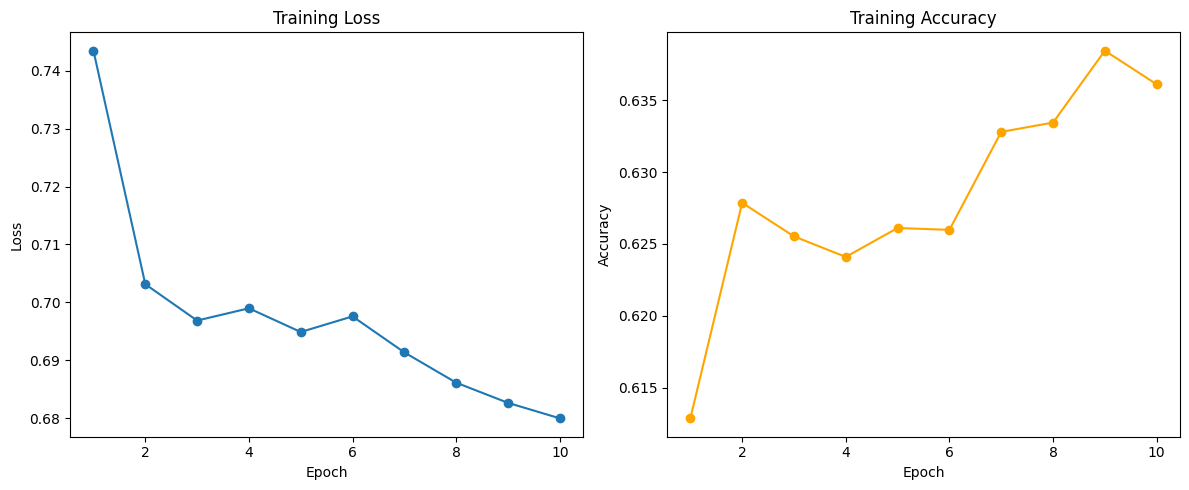

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, training_epochs+1), loss_history, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, training_epochs+1), accuracy_history, marker='o', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

## Confusion Matrix


Classification Report:

              precision    recall  f1-score   support

           0     0.9324    0.5018    0.6525       825
           1     0.4300    0.8970    0.5813       825
           2     0.8248    0.5648    0.6705       825
           3     0.8123    0.5612    0.6638       825

    accuracy                         0.6312      3300
   macro avg     0.7499    0.6312    0.6420      3300
weighted avg     0.7499    0.6312    0.6420      3300



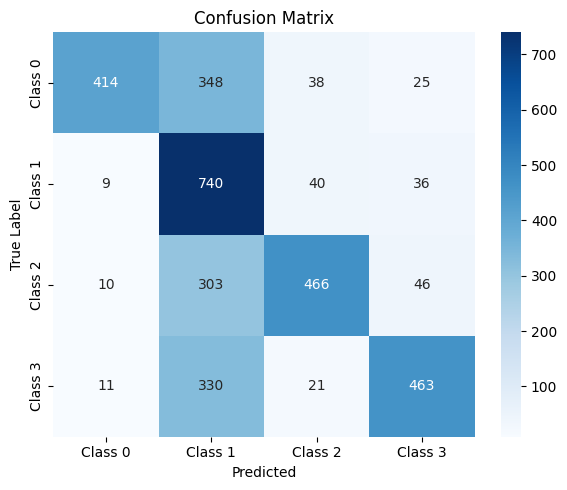

In [10]:

# Step 1: Run model on test set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(yb.cpu().numpy())

# Step 2: Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Optional: Print classification report
print("\nClassification Report:\n")
print(classification_report(all_targets, all_preds, digits=4))

# Step 3: Visualize
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
            yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


# Save

In [11]:
model_name = "resnet18_4class_JPEG_Attack_New.pth"
torch.save(model, f'/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/{model_name}')  # saves both architecture + weights



#torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/{model_name}')
